In [ ]:
!pip install torchvision

In [ ]:
import torch
import torchvision
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets


In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from torchvision import transforms

In [ ]:
import os
from PIL import Image
from torch.utils.data import Dataset, DataLoader

In [ ]:
class FaceDataset(Dataset):
  def __init__(self,image_dir,transform=None):
    self.image_dir=image_dir
    self.transform=transform
    self.image_filenames=sorted(os.listdir(self.image_dir))
  def __len__(self):
    return len(self.image_filenames)
  def __getitem__(self,idx):
    image_path=os.path.join(self.image_dir,self.image_filenames[idx])
    image=Image.open(image_path).convert('L')
    if self.transform:
      image=self.transform(image)
    return image

In [ ]:
transform1=transforms.Compose([transforms.Resize((128,128),interpolation=Image.NEAREST),
                              transforms.ToTensor(),
                              transforms.Normalize(mean=[0.5],std=[0.5])])

data_dir='/content/drive/MyDrive/faces_augmented'

In [ ]:
train_data=FaceDataset(image_dir=data_dir,transform=transform1)

In [ ]:
total_data=len(train_data)
print(total_data)

206


In [ ]:
print(len(train_data[0]))
print(train_data[0].shape)

1
torch.Size([1, 128, 128])


In [ ]:
print(len(train_data))

206


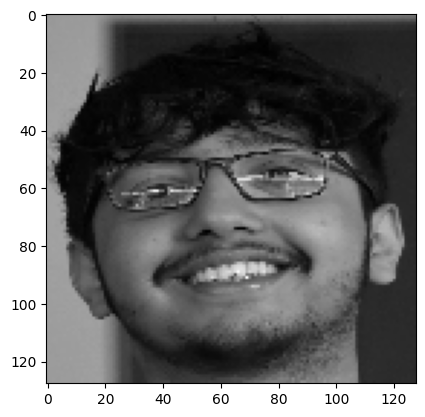

In [ ]:

plt.imshow(train_data[0].squeeze(0),cmap='gray')

In [ ]:
from torch.utils.data import Dataset,DataLoader
train_dataloader=DataLoader(train_data,batch_size=16,shuffle=True)

In [ ]:
print(len(train_dataloader))

13


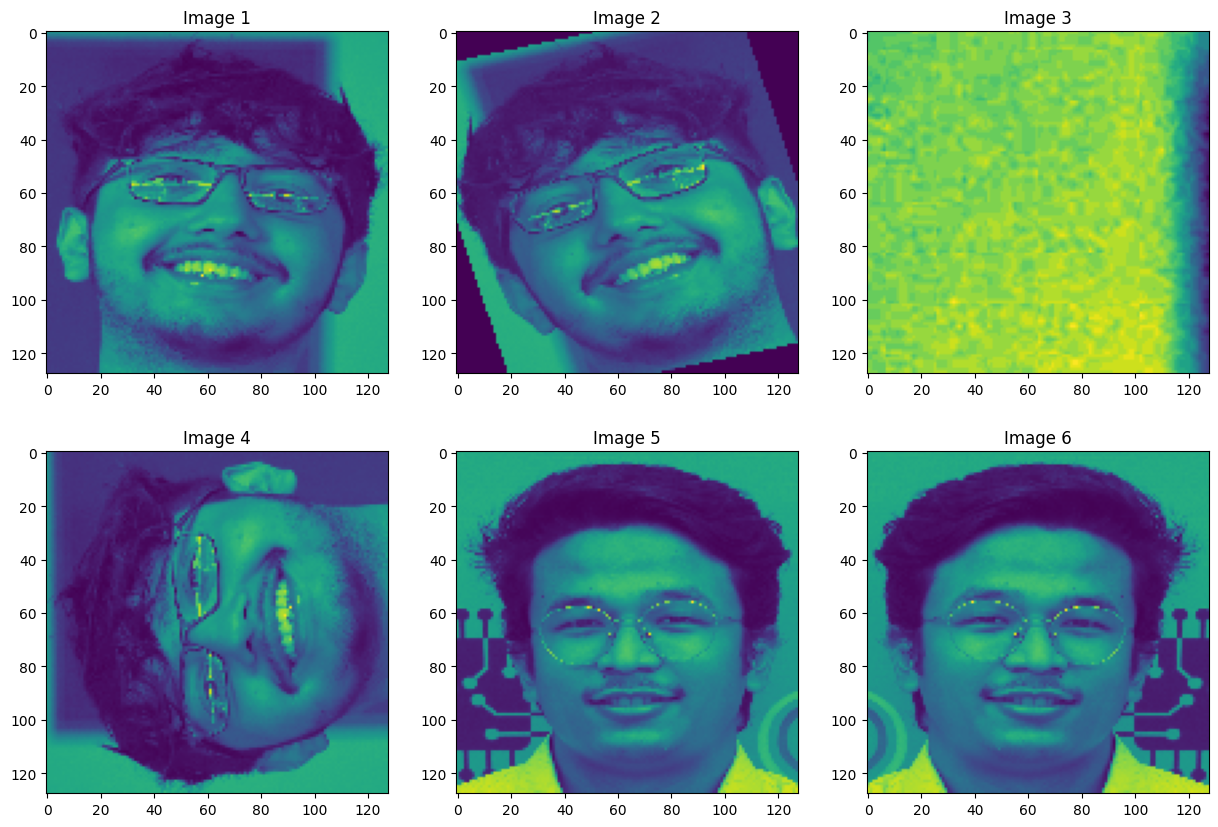

In [ ]:
plt.figure(figsize=(15,10))
for i in range(1,7):
  plt.subplot(2,3,i)
  plt.title(f'Image {i}')
  img=np.array(train_data[i].squeeze(0))
  plt.imshow(img)

In [ ]:
import torch.nn as nn
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()

    self.conv1=nn.Conv2d(1,64,kernel_size=4,stride=2,padding=1)
    self.leaky=nn.LeakyReLU(0.2,inplace=True)

    self.conv2=nn.Conv2d(64,128,kernel_size=4,stride=2,padding=1)
    self.batch_norm1=nn.BatchNorm2d(128)

    self.conv3=nn.Conv2d(128,256,kernel_size=4,stride=2,padding=1)
    self.batch_norm2=nn.BatchNorm2d(256)

    self.conv4=nn.Conv2d(256,512,kernel_size=4,stride=2,padding=1)
    self.batch_norm3=nn.BatchNorm2d(512)

    self.conv5=nn.Conv2d(512,1,kernel_size=8,stride=1,padding=0)
    self.sig=nn.Sigmoid()


  def forward(self, x):
    x=self.conv1(x)
    x=self.leaky(x)
    x=self.conv2(x)
    x=self.batch_norm1(x)
    x=self.leaky(x)
    x=self.conv3(x)
    x=self.batch_norm2(x)
    x=self.leaky(x)
    x=self.conv4(x)
    x=self.batch_norm3(x)
    x=self.leaky(x)
    x=self.conv5(x)
    x=self.sig(x)

    return x.view(-1,1)


In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.fc1=nn.Linear(100,512*8*8)
    self.relu=nn.ReLU()
    self.unflat=nn.Unflatten(1,(512,8,8))

    self.dconv1=nn.ConvTranspose2d(512,256,kernel_size=4,stride=2,padding=1)
    self.batch_norm1=nn.BatchNorm2d(256)

    self.dconv2=nn.ConvTranspose2d(256,128,kernel_size=4,stride=2,padding=1)
    self.batch_norm2=nn.BatchNorm2d(128)

    self.dconv3=nn.ConvTranspose2d(128,64,kernel_size=4,stride=2,padding=1)
    self.batch_norm3=nn.BatchNorm2d(64)

    self.dconv4=nn.ConvTranspose2d(64,1,kernel_size=4,stride=2,padding=1)
    self.tanh=nn.Tanh()

  def forward(self,x):
    x=self.fc1(x)
    x=self.relu(x)
    x=self.unflat(x)

    x=self.dconv1(x)
    x=self.batch_norm1(x)
    x=self.relu(x)

    x=self.dconv2(x)
    x=self.batch_norm2(x)
    x=self.relu(x)

    x=self.dconv3(x)
    x=self.batch_norm3(x)
    x=self.relu(x)

    x=self.dconv4(x)
    x=self.tanh(x)

    return x


In [ ]:
model1=Discriminator()
model2=Generator()
model1.to(device)
model2.to(device)

Generator(
  (fc1): Linear(in_features=100, out_features=32768, bias=True)
  (relu): ReLU()
  (unflat): Unflatten(dim=1, unflattened_size=(512, 8, 8))
  (dconv1): ConvTranspose2d(512, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch_norm1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv2): ConvTranspose2d(256, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch_norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv3): ConvTranspose2d(128, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (batch_norm3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (dconv4): ConvTranspose2d(64, 1, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (tanh): Tanh()
)

In [ ]:
criterion=nn.BCELoss()

In [ ]:
import torch.optim as optim
optimizer1=optim.Adam(model1.parameters(),lr=0.0002)
optimizer2=optim.Adam(model2.parameters(),lr=0.0002)

In [ ]:
num_epochs=300
generator_loss=[]
discriminator_loss=[]

In [ ]:
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.transforms.functional import resize
import torchvision.transforms as T

fid = FrechetInceptionDistance(normalize=True).to(device)


def to_rgb(x):
    return x.repeat(1, 3, 1, 1)


Epoch 10 → FID Score: 489.54
Epoch 20 → FID Score: 466.47
Epoch 30 → FID Score: 391.67
Epoch 40 → FID Score: 441.58
Epoch 50 → FID Score: 385.00
Epoch 60 → FID Score: 341.70
Epoch 70 → FID Score: 364.87
Epoch 80 → FID Score: 324.69
Epoch 90 → FID Score: 343.83
Epoch 100 → FID Score: 304.42
Epoch 110 → FID Score: 346.45
Epoch 120 → FID Score: 275.84
Epoch 130 → FID Score: 285.94
Epoch 140 → FID Score: 297.74
Epoch 150 → FID Score: 277.93
Epoch 160 → FID Score: 263.67
Epoch 170 → FID Score: 307.59
Epoch 180 → FID Score: 271.51
Epoch 190 → FID Score: 311.83
Epoch 200 → FID Score: 339.59


/tmp/ipython-input-69-162131758.py:54: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(15, 10))


Epoch 210 → FID Score: 338.97
Epoch 220 → FID Score: 296.15
Epoch 230 → FID Score: 271.90
Epoch 240 → FID Score: 300.33
Epoch 250 → FID Score: 288.30
Epoch 260 → FID Score: 309.10
Epoch 270 → FID Score: 274.77
Epoch 280 → FID Score: 275.02
Epoch 290 → FID Score: 270.16
Epoch 300 → FID Score: 268.41


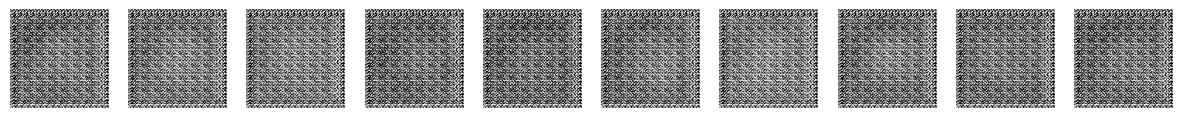

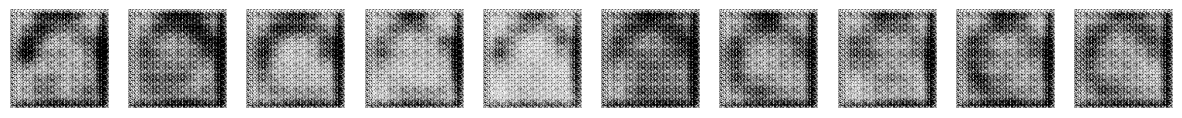

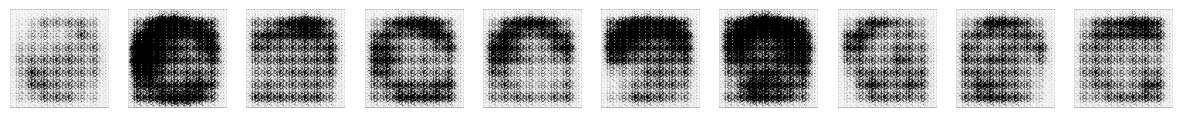

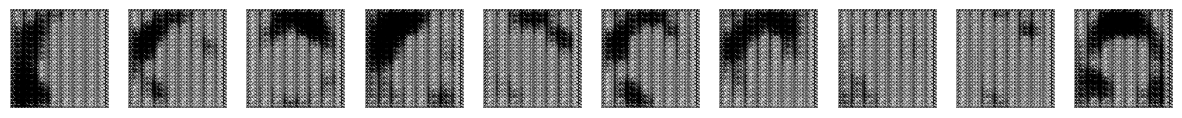

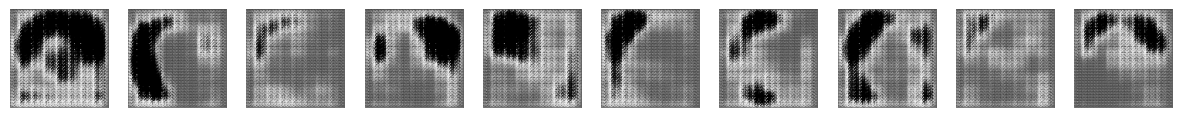

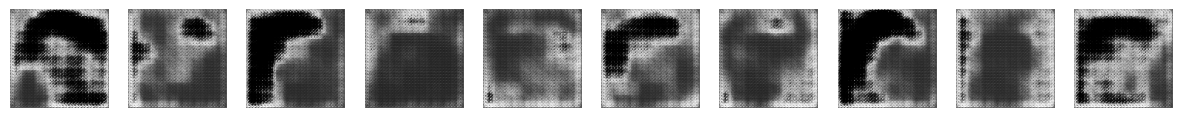

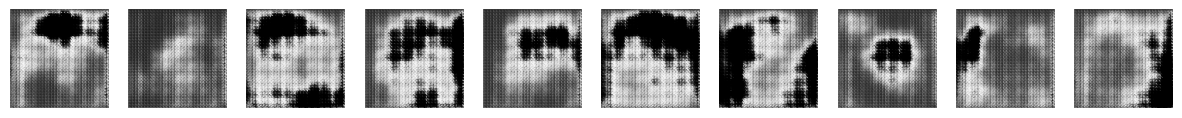

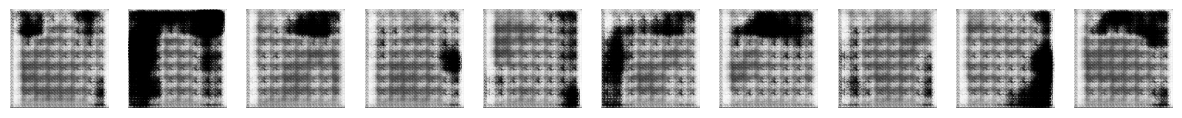

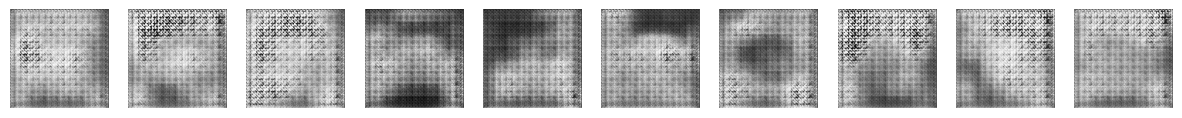

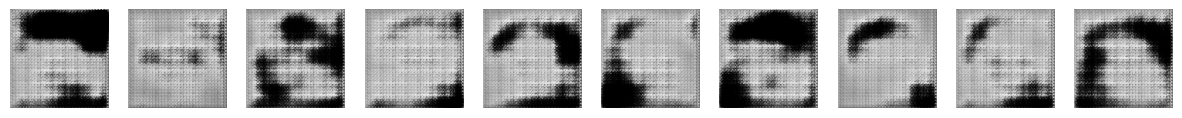

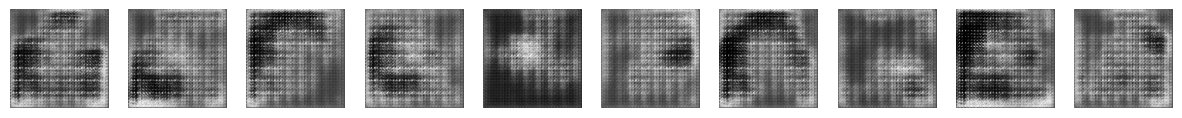

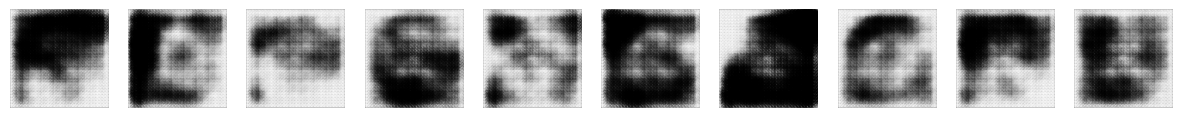

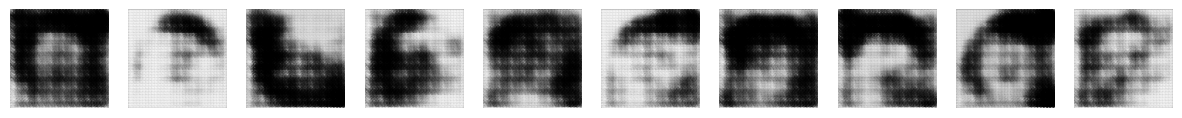

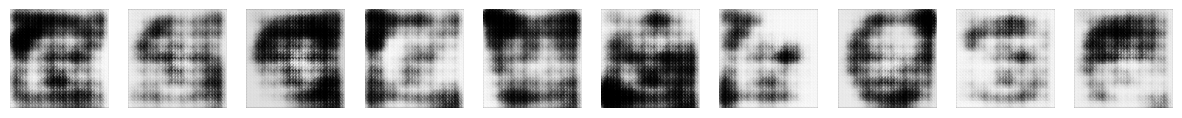

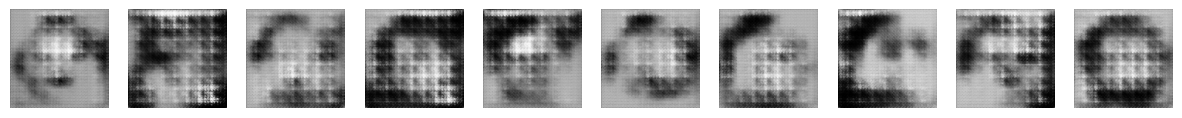

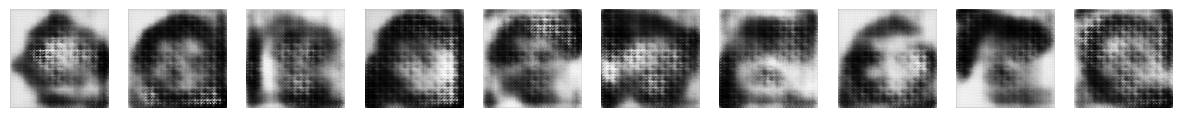

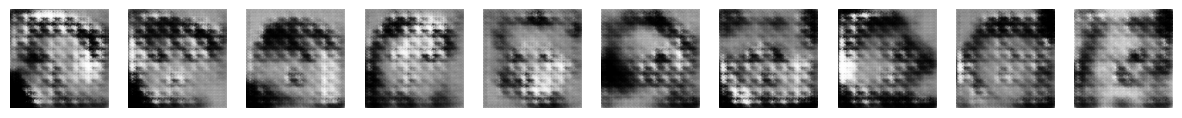

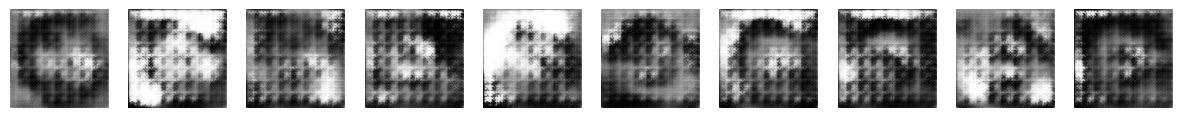

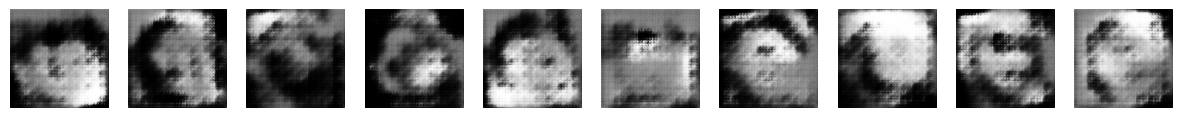

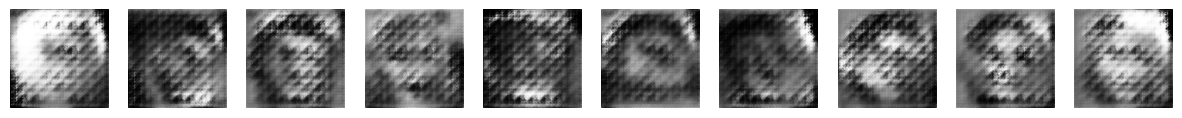

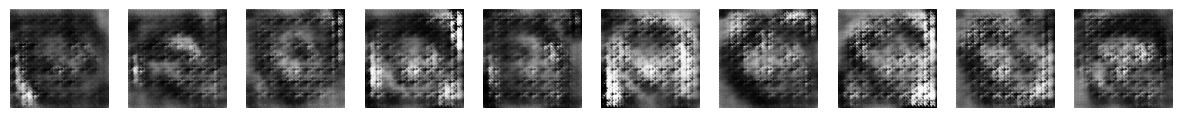

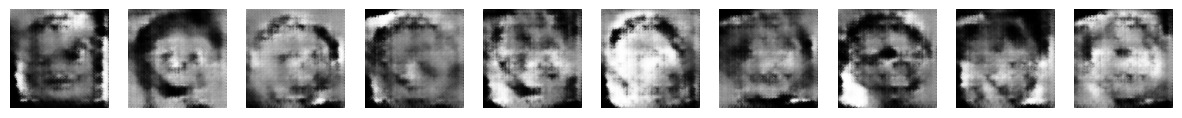

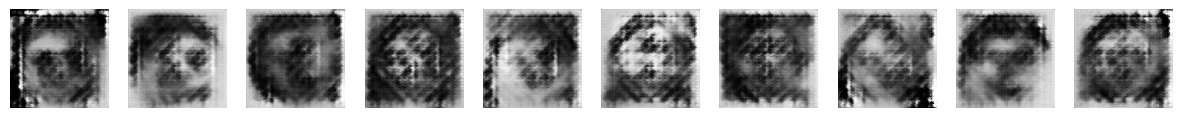

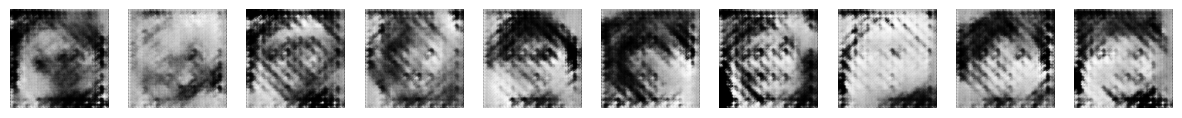

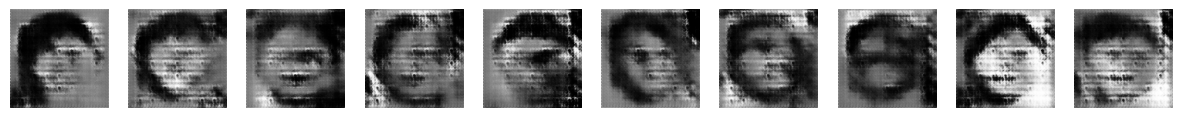

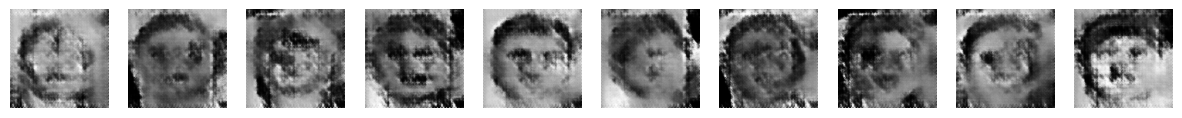

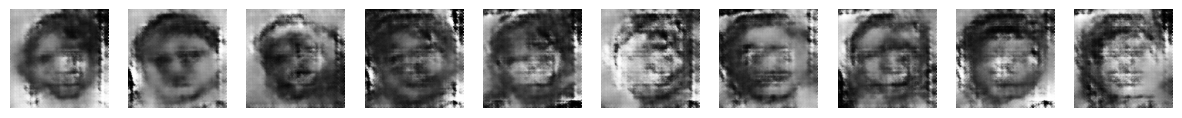

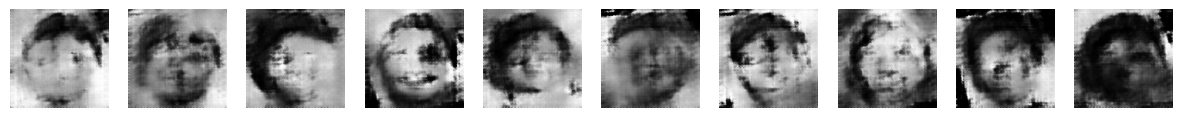

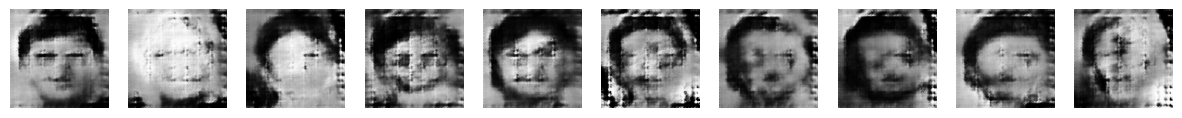

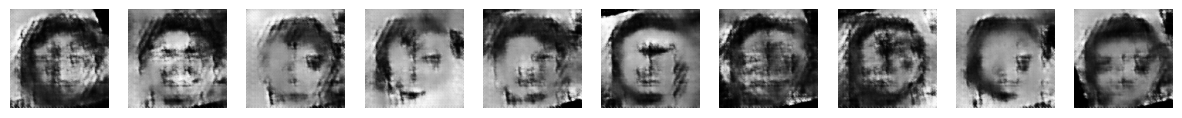

In [ ]:
for epoch in range(num_epochs):
    d_epoch_loss = 0
    g_epoch_loss = 0

    for i, (images) in enumerate(train_dataloader):
        real_labels = torch.ones(len(images), 1).to(device)
        fake_labels = torch.zeros(len(images), 1).to(device)
        images = images.to(device)

        try:
            # Discriminator Training
            output = model1(images)
            d_real_loss = criterion(output, real_labels)
            real_score = output

            fake_image = model2(torch.randn(len(images), 100).to(device))

            output = model1(fake_image)
            d_fake_loss = criterion(output, fake_labels)
            fake_score = output

            d_loss = d_real_loss + d_fake_loss
            d_epoch_loss += d_loss.item()
            optimizer1.zero_grad()
            d_loss.backward()
            optimizer1.step()

            # Generation Training
            fake_images = model2(torch.randn(len(images), 100).to(device))
            outputs = model1(fake_images)

            g_loss = criterion(outputs, real_labels)
            g_epoch_loss += g_loss.item()

            optimizer2.zero_grad()
            g_loss.backward()
            optimizer2.step()

            if (i + 1) % 200 == 0:
                print(f'Epoch: [{epoch + 1}/{num_epochs}] Batch/Steps: [{i + 1}/{len(train_dataloader)}] '
                      f'Disc. Loss: {d_loss.item()} Gen. Loss: {g_loss.item()} '
                      f'D(x): {real_score.mean().item()} D(G(z)): {fake_score.mean().item()} ')

        except Exception as e:
            # If an error occurs (e.g., corrupted image), skip this batch
            print(f"Skipping batch {i + 1} due to error: {str(e)}")
            continue

    generator_loss.append(g_epoch_loss / (i + 1))
    discriminator_loss.append(d_epoch_loss / (i + 1))

    if (epoch + 1) % 10 == 0:
        plt.figure(figsize=(15, 10))
        for i in range(10):
            plt.subplot(1, 10, i + 1)
            img = fake_images[i, 0].detach().cpu().numpy()
            plt.imshow(img, cmap='gray')
            plt.axis('off')
        fid.reset()

        # Collect real image samples
        real_iter = iter(train_dataloader)
        for _ in range(5):
            try:
                real_batch = next(real_iter).to(device)
                real_batch = to_rgb(real_batch)
                real_batch = resize(real_batch, [299, 299])
                fid.update(real_batch, real=True)
            except:
                continue

        # Generate fake images
        with torch.no_grad():
            noise = torch.randn(100, 100).to(device)
            fake_batch = model2(noise)
            fake_batch = to_rgb(fake_batch)
            fake_batch = resize(fake_batch, [299, 299])
            fid.update(fake_batch, real=False)

        fid_score = fid.compute().item()
        print(f"Epoch {epoch+1} → FID Score: {fid_score:.2f}")




In [ ]:
!ls

drive  sample_data


In [ ]:
torch.save(model1,'/content/drive/MyDrive/dcgan/discriminator_class_final.pt')
torch.save(model2,'/content/drive/MyDrive/dcgan/generator_class_final.pt')

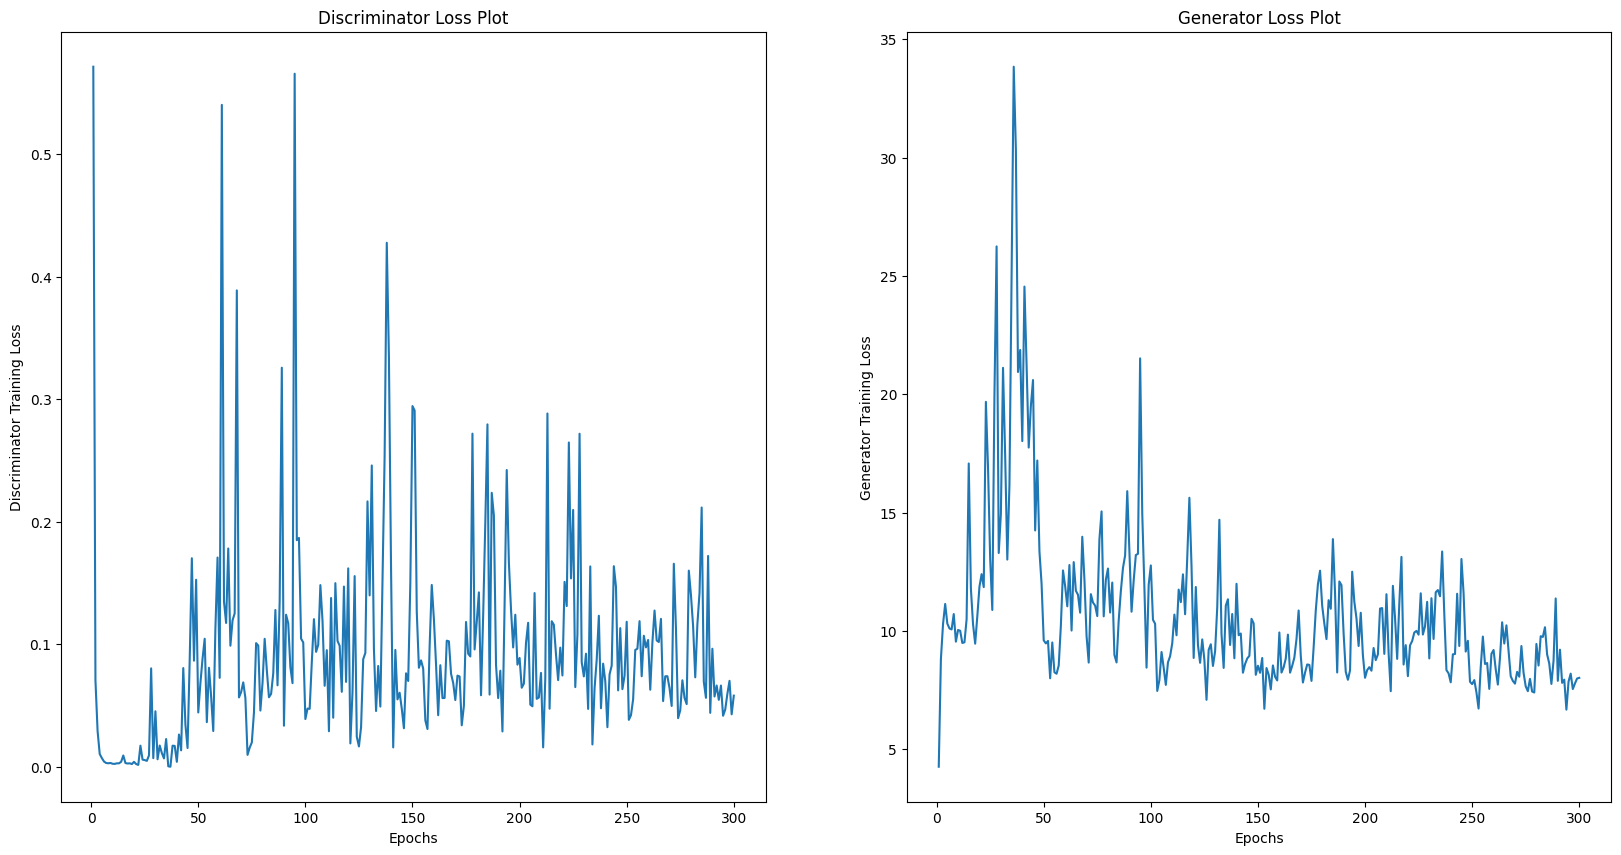

In [ ]:
plt.figure(figsize=(20,10))
plt.subplot(1,2,1)
plt.title('Discriminator Loss Plot')
train_num_epoch=[i+1 for i in range(len(discriminator_loss))]
plt.plot(train_num_epoch,discriminator_loss)
plt.xlabel('Epochs')
plt.ylabel('Discriminator Training Loss')

plt.subplot(1, 2, 2)
plt.title("Generator Loss Plot")
train_num_epoch = [i + 1 for i in range(len(discriminator_loss))]
plt.plot(train_num_epoch, generator_loss)
plt.xlabel("Epochs")
plt.ylabel("Generator Training Loss")
plt.show()

# Inference

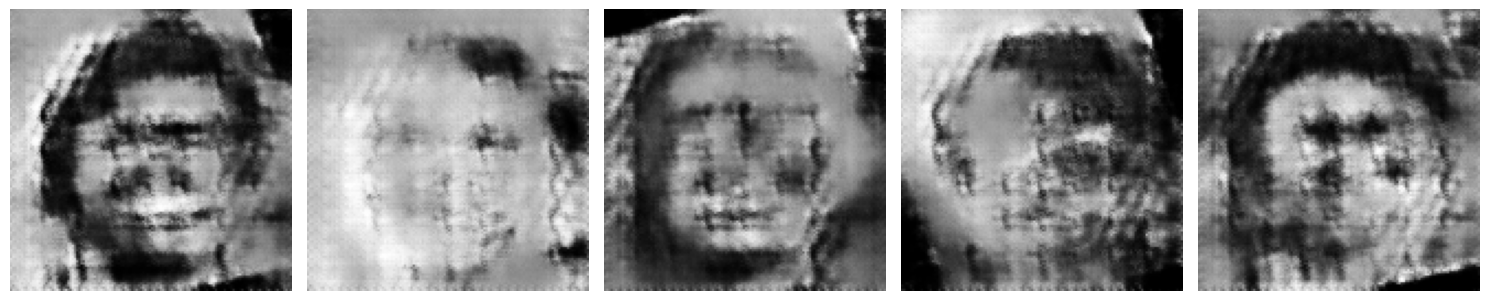

In [ ]:

from torch.serialization import add_safe_globals
from torch.nn import LeakyReLU
import matplotlib.pyplot as plt

add_safe_globals([nn.Linear, LeakyReLU])
generator = torch.load('/content/drive/MyDrive/dcgan/generator_class_final.pt', weights_only=False)
generator.eval()

num_samples = 5
input_noise = torch.randn(num_samples, 100).to(device)
generated_samples = generator(input_noise)
generated_samples = generated_samples.reshape(num_samples, 1, 128, 128)

generated_samples_np = generated_samples.detach().cpu().numpy()
plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(1, num_samples, i+1)
    plt.imshow(generated_samples_np[i, 0], cmap='gray')
    plt.axis('off')
plt.tight_layout()
plt.show()


In [ ]:
!pip install torchmetrics

In [ ]:
!pip install torch-fidelity

In [ ]:
import torch
from torchvision.utils import make_grid
from torchmetrics.image.fid import FrechetInceptionDistance
from torchvision.transforms.functional import resize
import torchvision.transforms as T

fid = FrechetInceptionDistance(normalize=True).to(device)
def to_rgb(images):
    return images.repeat(1, 3, 1, 1)

real_images_list = []
for i, real_images in enumerate(train_dataloader):
    if i >= 10:
        break
    real_images = real_images.to(device)
    real_images = to_rgb(real_images)
    real_images = resize(real_images, [299, 299])
    fid.update(real_images, real=True)
    real_images_list.append(real_images)
generator.eval()
with torch.no_grad():
    noise = torch.randn(100, 100).to(device)
    fake_images = generator(noise)
    fake_images = to_rgb(fake_images)
    fake_images = resize(fake_images, [299, 299])
    fid.update(fake_images, real=False)

# 3. Compute FID
fid_score = fid.compute()
print(f"FID Score: {fid_score.item():.2f}")


FID Score: 272.26
